# Notebook for Data Science Final Project: Trying to make a model to predict the rating of a video game in the steam dataset

## Authors: Stuart Harley, Kyle Rodrigues, Matt Haas

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Load Dataset / Adjust Features

In [2]:
# sometimes steam.csv is the one that works, other times it is /steam.csv
# df = pd.read_csv("/steam.csv")
df = pd.read_csv("steam.csv")

In [3]:
# Creating a release_month column taking the month value from the release_date column.
# I feel like the month the game is released might affect the ratings it gets... we'll see if that is true
df['release_month'] = pd.DatetimeIndex(df['release_date']).month

# I am not doing the same for the year because the application of this model would be to predict the rating of a new game,
# and any new game will have the most recent year so past years probably won't predict it?

In [4]:
# this would be our output/ response variable
df["rating"] = df["positive_ratings"] / (df["positive_ratings"] + df["negative_ratings"]) * 100

For the sake of this analysis, we will be removing some features that we don't want to use for our analysis. We also need to change the datatypes for some of the features.

In [5]:
# For developer and publisher, there are too many unique values to make it a usable categorical variable ~15k each
# I think we would have to categorize each game developer as small/medium/large or something but that would take a lot of work
df = df.drop('appid', 1)
df = df.drop('release_date', 1)
df = df.drop('developer', 1)
df = df.drop('publisher', 1)


df = df[df.owners != '0-20000']
df.reset_index(inplace=True,drop=True)

,name,english,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,release_month,rating
0,Counter-Strike,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,11,97.388815
1,Team Fortress Classic,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,4,83.978740
2,Day of Defeat,1,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,5,89.564761
3,Deathmatch Classic,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,6,82.662338
4,Half-Life: Opposing Force,1,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,11,94.799567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Civilization IV®: Warlords,1,windows;mac,0,Single-player,Strategy,Strategy;Turn-Based;4X,0,121,20,0,0,1000000-2000000,2.99,4,85.815603
121,Garry's Mod,1,windows;mac;linux,0,Single-player;Multi-player;Co-op;Cross-Platfor...,Indie;Simulation,Sandbox;Multiplayer;Funny,29,363721,16433,12422,1875,10000000-20000000,6.99,11,95.677278
122,RACE - The WTCC Game,1,windows,0,Single-player;Multi-player,Racing,Racing;Simulation,0,119,43,0,0,200000-500000,25.99,11,73.456790
123,RoboBlitz,1,windows,0,Single-player;Partial Controller Support;Inclu...,Action;Indie,Action;Indie;Puzzle,0,43,14,78,78,20000-50000,5.99,11,75.438596


In [6]:
# converting relevant columns to categorical variables
df["owners"] = df["owners"].astype('category')
df["required_age"] = df["required_age"].astype('category')
df["categories"] = df["categories"].astype('category')
df["genres"] = df["genres"].astype('category')
df["steamspy_tags"] = df["steamspy_tags"].astype('category') # there does seem to be overlap between this column and genres
df["platforms"] = df["platforms"].astype('category')
df["release_month"] = df["release_month"].astype('category')
df["english"] = df["english"].astype('category')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8479 entries, 0 to 8478
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   name              8479 non-null   object  
 1   english           8479 non-null   category
 2   platforms         8479 non-null   category
 3   required_age      8479 non-null   category
 4   categories        8479 non-null   category
 5   genres            8479 non-null   category
 6   steamspy_tags     8479 non-null   category
 7   achievements      8479 non-null   int64   
 8   positive_ratings  8479 non-null   int64   
 9   negative_ratings  8479 non-null   int64   
 10  average_playtime  8479 non-null   int64   
 11  median_playtime   8479 non-null   int64   
 12  owners            8479 non-null   category
 13  price             8479 non-null   float64 
 14  release_month     8479 non-null   category
 15  rating            8479 non-null   float64 
dtypes: category(8), float64(

using p-value of 0.01
#### Linear Regression Tests

| Variable Name | p-value  | statistically significant |
|---------------|----------|---------------------------|
| average_playtime       | 0.00079     | yes                        |
| median_playtime      | 0.29 | no                       |
| price       | 2.16e-36 | yes                       |
| achievements | 0.00022 | yes |

In [8]:
# headers = ["positive_ratings", "negative_ratings", "average_playtime", "median_playtime", "price", "english"]
# I don't think we should include positive and negative ratings in our model. If we knew the positive and negative
# ratings of a game when trying to predict the rating of a video game, we could just calculate it instead of needing the model.

# The use case of the model would be to try to predict what rating a game would get before it is released/rated.

headers = ["average_playtime", "median_playtime", "price", "achievements"]

for name in headers:
    _, _, _, p, _ = stats.linregress(df["rating"], df[name])
    r, _ = stats.pearsonr(df["rating"], df[name])
    print(name, "versus rating: p-value =", p, "\npearson correlation coefficient =", r, "\n")

average_playtime versus rating: p-value = 0.0007377162599913078 
pearson correlation coefficient = 0.03664719505209067 

median_playtime versus rating: p-value = 0.03969126323179251 
pearson correlation coefficient = 0.02233884729939114 

price versus rating: p-value = 1.5625976957597286e-45 
pearson correlation coefficient = 0.15292149182807477 

achievements versus rating: p-value = 0.018178462037296665 
pearson correlation coefficient = -0.02565035205203027 



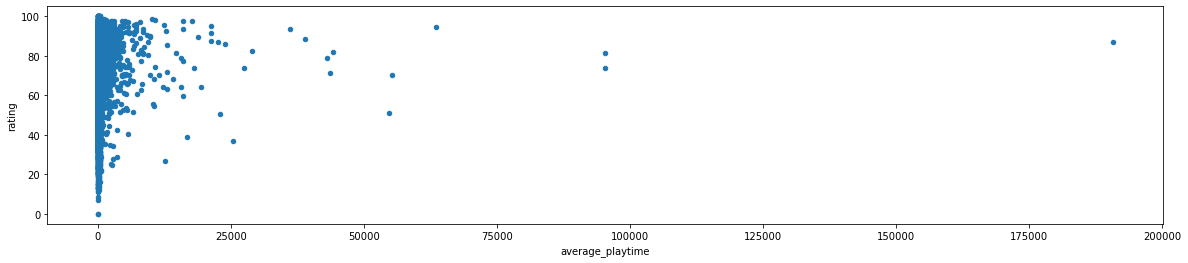

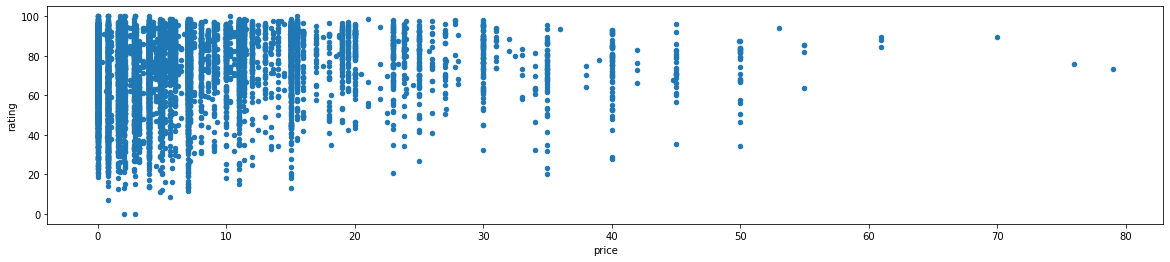

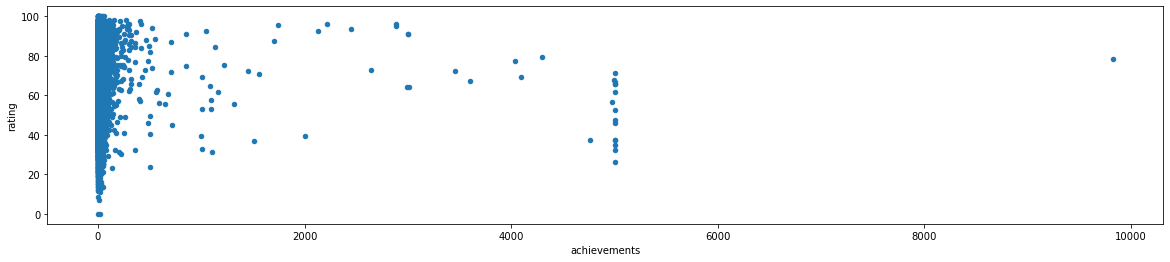

In [9]:
# Plotting scatter plots of the predictive numerical variables
df.plot.scatter(x='average_playtime', y='rating', figsize=(20,4))
df.plot.scatter(x='price', y='rating', figsize=(20,4));
df.plot.scatter(x='achievements', y='rating', figsize=(20,4));

using p-value of 0.01
#### Kruskal-Wallis Tests

| Variable Name | p-value  | statistically significant |
|---------------|----------|---------------------------|
| required age | .41 | no |
| categories          | 3.19e-29 | yes                       |
| genres   | 1.76e-67 | yes |
| steamspy_tags        | 5.65e-14     | yes                        |
| owners       | 5.24e-41 | yes                       |
| platforms       | 2.33e-89 | yes                       |
| release_month | 7.80e-06 | yes |
| english | 7.20e-05 | yes |

In [10]:
headers = ["required_age", "categories", "genres", "steamspy_tags", "owners", "platforms", "release_month", "english"]

for name in headers:
    samples_by_group = []
    for value in set(df[name]):
        mask = df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    print(name, "versus rating: p-value =", p)

required_age versus rating: p-value = 0.006196189364389729
categories versus rating: p-value = 2.980035855510931e-20
genres versus rating: p-value = 3.2375015914412077e-20
steamspy_tags versus rating: p-value = 5.5997269711901285e-27
owners versus rating: p-value = 1.4453473612126944e-62
platforms versus rating: p-value = 3.423304406077233e-81
release_month versus rating: p-value = 0.03622843060491119
english versus rating: p-value = 0.2926425829733527


#### Graphical Testing

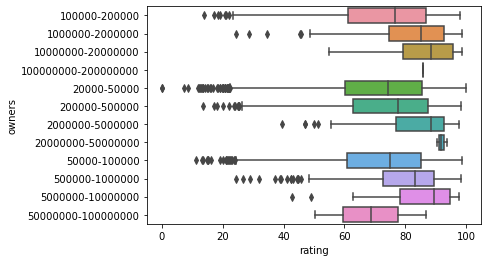

In [11]:
# Plotting boxplots of the predictive categorical variables
# sns.boxplot(x='categories', y='rating', data=df)    These 3 have too many unique values, the boxplots take too long and wouldn't be readable
# sns.boxplot(x='genres', y='rating', data=df)        However, we break up the unique values during one-hot encoding so this wouldn't accurately represent anyways
# sns.boxplot(x='steamspy_tags', y='rating', data=df)
sns.boxplot(x='rating', y='owners', data=df);

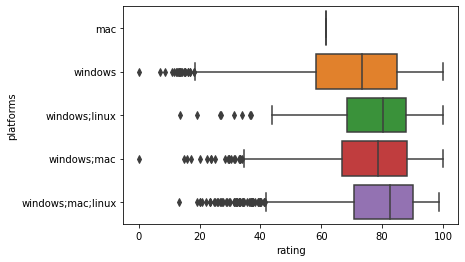

In [12]:
sns.boxplot(x='rating', y='platforms', data=df);

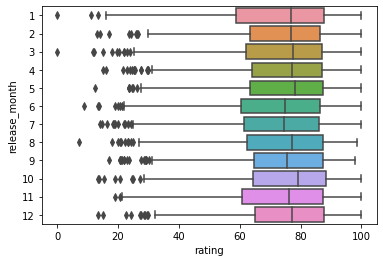

In [13]:
# Based off the boxplot, I would say month really isn't that predictive even tho it had a stat. sig. p-value
sns.boxplot(x='rating', y='release_month', data=df);

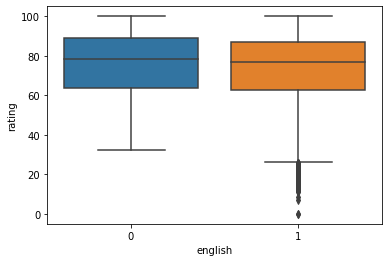

In [14]:
sns.boxplot(x='english', y='rating', data=df);

#### One Hot Encode Features

Attempt to deal with the categorical variables with a one hot encoded matrix is below.

In [15]:
def oneHotEncodedDfFromNumberSeries(name, prefix):
  return pd.get_dummies(df[name], prefix=prefix)


# takes series with values like Action;Adventure;Horror and makes a one hot encoded df with columns Action, Adventure, and Horror
def oneHotEncodedDfFromStringSeries(name, prefix):
  # split on ; and get dummies from resulting matrix
  new_df = pd.get_dummies(df[name].str.split(';', expand=True), prefix=prefix)
  # above results in duplicated column names create set of expected column names
  column_names = list(set(new_df.columns))
  # group by expected columns names
  new_df = new_df.groupby(column_names, level=0, axis=1).max()
  return new_df

In [16]:
# Takes the feature name, iterates through column and extracts unique values
def oneHotEncodingSplit(name):
    # Create set to avoid having duplicate values
    features = set([])

    # Iterate through feature
    for x in range(len(df[name])):
        # Add the values found from spliting the string to features
        features.update(df[name][x].split(';'))
    return list(features)

# Will one hot encode a feature
def oneHotEncodingAggegate(name):
    # Get unique list of features from the feature column
    features = oneHotEncodingSplit(name)
    # Create empty 2d array to hold our one hot encoding
    features_values = np.zeros((len(df[name]), len(features)), dtype=int)
    
    # Iterate through full feature and update rows in features_values
    for x in range(len(df[name])):
        # Split values from feature
        vals = df[name][x].split(';')
        
        # Add values to features_values
        for v in range(len(vals)):
            col = features.index(vals[v])
            features_values[x][col] = 1
    
    # Adjust name and add to features
    name += ":"
    features = [name + feature for feature in features]
    
    # Add data and columns to dataframe
    new_df = pd.DataFrame(data=features_values, columns=features)
    return new_df

In [17]:
genre_df = oneHotEncodingAggegate("genres")
cat_df = oneHotEncodingAggegate("categories")
owner_df = oneHotEncodedDfFromStringSeries("owners", "owner")
age_df = oneHotEncodedDfFromNumberSeries("required_age", "age")
tag_df = oneHotEncodingAggegate("steamspy_tags")
platform_df = oneHotEncodingAggegate("platforms")

# will want to add positive/neg ratings, price, etc.
new_df = pd.concat([genre_df, cat_df, owner_df, age_df, tag_df], axis=1)
new_df

,genres:Design & Illustration,genres:Animation & Modeling,genres:Gore,genres:Early Access,genres:Massively Multiplayer,genres:RPG,genres:Adventure,genres:Sexual Content,genres:Casual,genres:Game Development,...,steamspy_tags:Masterpiece,steamspy_tags:Abstract,steamspy_tags:Cult Classic,steamspy_tags:Short,steamspy_tags:Military,steamspy_tags:Motocross,steamspy_tags:Wrestling,steamspy_tags:Cats,steamspy_tags:Political,steamspy_tags:Survival
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8476,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Visualization to help understand dataset and highly rated games

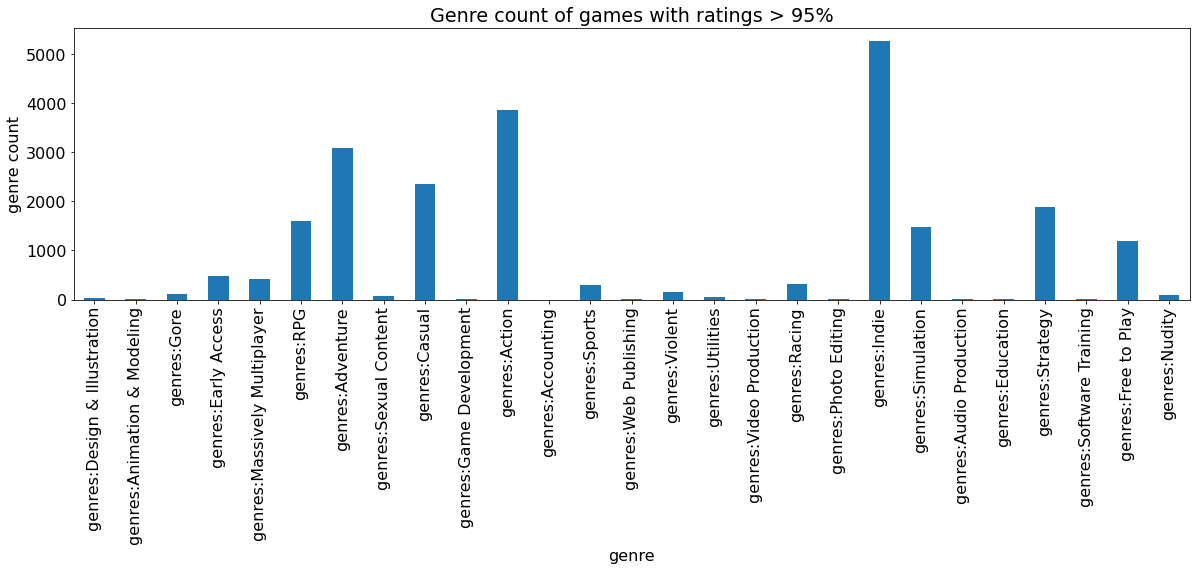

In [18]:
# print out most popular genres for games with rating > 95%
mask = df['rating'] > .95
popular_genre_count = genre_df[mask].sum()
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,5))
plt.xlabel('genre')
plt.ylabel('genre count')
plt.title('Genre count of games with ratings > 95%')
popular_genre_count.plot(kind='bar')

#### Statistic

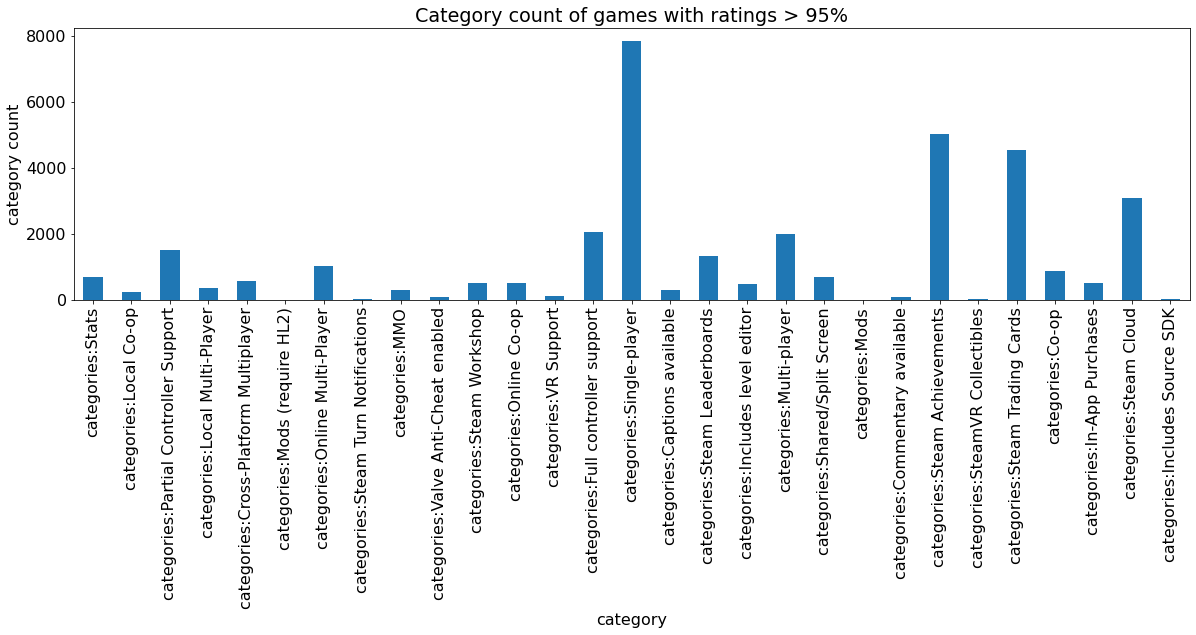

In [19]:
# print out most popular genres for games with rating > 95%
mask = df['rating'] > .95
popular_cat_count = cat_df[mask].sum()
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,5))
plt.xlabel('category')
plt.ylabel('category count')
plt.title('Category count of games with ratings > 95%')
popular_cat_count.plot(kind='bar')

using p-value of 0.01
#### Kruskal-Wallis Tests for platforms

| Variable Name | p-value  | statistically significant |
|---------------|----------|---------------------------|
| platforms:mac | 5.05e-81 | yes |
| platforms:linux | 7.55e-71 | yes |
| platforms:windows | .46 | no |

In [20]:
stat_df = pd.concat([df, platform_df], axis=1)
headers = ["platforms:mac", "platforms:linux", "platforms:windows"]

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    print(name, "versus rating: p-value =", p)

platforms:mac versus rating: p-value = 4.0209896511727516e-73
platforms:linux versus rating: p-value = 1.7442968945923128e-67
platforms:windows versus rating: p-value = 0.3618290561071478


using p-value of 0.01
#### Genres Kruskal-Wallis Tests - Only putting in statistically sig genre features

| Variable Name | p-value  | statistically significant |
|---------------|----------|---------------------------|
| genres:Violent | 1.02e-26 | yes |
| genres:Simulation | 2.47e-89 | yes |
| genres:Strategy | 1.48e-25 | yes |
| genres:Racing | 3.71e-13 | yes |
| genres:Gore | 4.81e-18 | yes |
| genres:Indie | 5.11e-19 | yes |
| genres:Sports | 7.98e-13 | yes |
| genres:Massively Multiplayer | 3.21e-57 | yes |
| genres:Free to Play | 4.28e-15 | yes |

In [21]:
stat_df = pd.concat([df, genre_df], axis=1)
headers = genre_df.columns

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    print(name, "versus rating: p-value =", p)

genres:Design & Illustration versus rating: p-value = 0.10674996783998172
genres:Animation & Modeling versus rating: p-value = 0.10014043652283929
genres:Gore versus rating: p-value = 0.001168953820943914
genres:Early Access versus rating: p-value = 2.487096539888663e-05
genres:Massively Multiplayer versus rating: p-value = 7.045082399025699e-43
genres:RPG versus rating: p-value = 0.454853507265622
genres:Adventure versus rating: p-value = 0.03423207424106657
genres:Sexual Content versus rating: p-value = 0.0031057333570609297
genres:Casual versus rating: p-value = 0.06274975231610422
genres:Game Development versus rating: p-value = 0.33568441831061885
genres:Action versus rating: p-value = 0.003051268195935146
genres:Accounting versus rating: p-value = 0.8357447037613519
genres:Sports versus rating: p-value = 0.0030753163621015755
genres:Web Publishing versus rating: p-value = 0.07096651149886643
genres:Violent versus rating: p-value = 0.0007945820879161177
genres:Utilities versus rat

using p-value of 0.01
#### Category Kruskal-Wallis Tests - Only putting in statistically sig category features

| Variable Name | p-value  | statistically significant |
|---------------|----------|---------------------------|
| categories:In-App Purchases | 6.93e-40 | yes |
| categories:SteamVR Collectibles | 1.53e-05 | yes |
| categories:Single-player | 2.83e-22 | yes |
| categories:Steam Workshop | 6.23e-18 | yes |
| categories:Includes level editor | 9.23e-17 | yes |
| categories:Full controller support | 2.88e-111 | yes |
| categories:Multi-player | 1.31e-11 | yes |
| categories:Steam Trading Cards | 6.24e-08 | yes |
| categories:Captions available | 1.49e-05 | yes |
| categories:Shared/Split Screen | 4.88e-34 | yes |
| categories:Steam Leaderboards | 1.50e-51 | yes |
| categories:Local Multi-Plauer | 2.81e-25 | yes |
| categories:Steam Cloud | 3.70e-178 | yes |
| categories:Stats | 4.89e-09 | yes |
| categories:Local Co-op | 8.44e-35 | yes |
| categories:Steam Achievements | 1.47e-110 | yes |
| categories:MMO | 3.86e-35 | yes |
| categories:Online Multi-Player | 1.70e-13 | yes |

In [22]:
stat_df = pd.concat([df, cat_df], axis=1)
headers = cat_df.columns

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    print(name, "versus rating: p-value =", p)

categories:Stats versus rating: p-value = 0.0042826420331625046
categories:Local Co-op versus rating: p-value = 8.961094687725238e-12
categories:Partial Controller Support versus rating: p-value = 0.377922489346026
categories:Local Multi-Player versus rating: p-value = 1.2186379407169724e-05
categories:Cross-Platform Multiplayer versus rating: p-value = 0.06154858153768373
categories:Mods (require HL2) versus rating: p-value = 0.4865778832419174
categories:Online Multi-Player versus rating: p-value = 8.535304604827194e-12
categories:Steam Turn Notifications versus rating: p-value = 0.9403174731766056
categories:MMO versus rating: p-value = 6.826798487903196e-35
categories:Valve Anti-Cheat enabled versus rating: p-value = 0.0017573690551244143
categories:Steam Workshop versus rating: p-value = 1.638123447201571e-22
categories:Online Co-op versus rating: p-value = 0.010909238232710184
categories:VR Support versus rating: p-value = 0.005222124877072341
categories:Full controller support v

#### Tags statistical testing (too many tags for a table)

In [23]:
stat_df = pd.concat([df, tag_df], axis=1)
headers = tag_df.columns

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    if p < 0.01:
      print(name, "versus rating: p-value =", p) # Printed out only the ones with stat sig values below

steamspy_tags:Massively Multiplayer versus rating: p-value = 9.553177952885284e-30
steamspy_tags:Visual Novel versus rating: p-value = 2.192112376177077e-21
steamspy_tags:Great Soundtrack versus rating: p-value = 2.7417229695417043e-19
steamspy_tags:Trains versus rating: p-value = 0.009692500313091865
steamspy_tags:Point & Click versus rating: p-value = 2.2850136230362148e-07
steamspy_tags:Dating Sim versus rating: p-value = 1.058071162190582e-07
steamspy_tags:Minimalist versus rating: p-value = 0.0007268723422909912
steamspy_tags:Metroidvania versus rating: p-value = 9.982955817743577e-07
steamspy_tags:Racing versus rating: p-value = 8.431003217381011e-05
steamspy_tags:Survival Horror versus rating: p-value = 0.0004246261940407429
steamspy_tags:Relaxing versus rating: p-value = 0.007115452046279349
steamspy_tags:Choose Your Own Adventure versus rating: p-value = 0.006393567657012509
steamspy_tags:FMV versus rating: p-value = 0.003593525986456252
steamspy_tags:First-Person versus ratin

In [24]:
# steamspy_tags:Hidden Object versus rating: p-value = 3.7720679039414733e-06
# steamspy_tags:Racing versus rating: p-value = 4.1608517788039506e-10
# steamspy_tags:Classic versus rating: p-value = 5.7632040450614064e-12
# steamspy_tags:Sports versus rating: p-value = 2.096353159466909e-08
# steamspy_tags:Survival versus rating: p-value = 1.820992973635471e-05
# steamspy_tags:Story Rich versus rating: p-value = 3.1628560304160253e-15
# steamspy_tags:Atmospheric versus rating: p-value = 1.4679797018173834e-05
# steamspy_tags:Difficult versus rating: p-value = 1.7051250422498404e-06
# steamspy_tags:Indie versus rating: p-value = 4.075579418422573e-18
# steamspy_tags:Cute versus rating: p-value = 4.491018942810672e-08
# steamspy_tags:Violent versus rating: p-value = 1.1226939133822612e-06
# steamspy_tags:Platformer versus rating: p-value = 2.1729306336034476e-13
# steamspy_tags:Pixel Graphics versus rating: p-value = 4.199819716488478e-16
# steamspy_tags:Comedy versus rating: p-value = 4.95015507105542e-07
# steamspy_tags:Visual Novel versus rating: p-value = 5.3941474791739105e-46
# steamspy_tags:Strategy versus rating: p-value = 4.9033923958775076e-27
# steamspy_tags:Simulation versus rating: p-value = 1.512505571599535e-74
# steamspy_tags:Great Soundtrack versus rating: p-value = 7.608506931549131e-18
# steamspy_tags:Massively Multiplayer versus rating: p-value = 8.6090308133058e-42
# steamspy_tags:Point & Click versus rating: p-value = 2.3211947426018425e-05
# steamspy_tags:Action versus rating: p-value = 2.0152190395112622e-06
# steamspy_tags:Free to Play versus rating: p-value = 7.681015527243406e-11
# steamspy_tags:Anime versus rating: p-value = 3.444378246467507e-27
# steamspy_tags:Co-op versus rating: p-value = 1.859956812688745e-05
# steamspy_tags:Choices Matter versus rating: p-value = 8.67456612254754e-05
# steamspy_tags:Twin Stick Shooter versus rating: p-value = 5.1326067695948696e-05
# steamspy_tags:Local Multiplayer versus rating: p-value = 1.3221485122082695e-05
# steamspy_tags:Puzzle versus rating: p-value = 5.17487804145188e-46
# steamspy_tags:Bullet Hell versus rating: p-value = 5.583361302830714e-09
# steamspy_tags:Shoot 'Em Up versus rating: p-value = 2.05518061641716e-09

#### Applying Models

#### Experiment 1 (combined significant categorical and numeric variables)

Result: Combined performed the best of all our experiments but the difference was negligible.

In [25]:
# Combining the one-hot encoding matrix and the other predictive features into one df
# Predictive features: english, achievements, average_playtime, price, platforms(mac & linux), age, owner, genre(some), category(some), steamspy_tag(some)

pred_df = pd.concat([df[['name', 'english', 'achievements', 'average_playtime', 'price']], platform_df[['platforms:linux', 'platforms:mac']], age_df, owner_df,
                     genre_df[['genres:Violent', 'genres:Simulation', 'genres:Strategy', 'genres:Racing', 'genres:Gore', 'genres:Indie', 'genres:Sports',
                               'genres:Massively Multiplayer', 'genres:Free to Play']],
                     cat_df[['categories:In-App Purchases', 'categories:SteamVR Collectibles', 'categories:Single-player', 'categories:Steam Workshop',
                             'categories:Includes level editor', 'categories:Full controller support', 'categories:Multi-player', 'categories:Steam Trading Cards',
                             'categories:Captions available', 'categories:Shared/Split Screen', 'categories:Steam Leaderboards', 'categories:Local Multi-Player',
                             'categories:Steam Cloud', 'categories:Stats', 'categories:Local Co-op', 'categories:Steam Achievements', 'categories:MMO',
                             'categories:Online Multi-Player']],
                     tag_df[['steamspy_tags:Hidden Object', 'steamspy_tags:Racing', 'steamspy_tags:Classic', 'steamspy_tags:Sports', 'steamspy_tags:Survival',
                             'steamspy_tags:Story Rich', 'steamspy_tags:Atmospheric', 'steamspy_tags:Difficult', 'steamspy_tags:Indie', 'steamspy_tags:Cute',
                             'steamspy_tags:Violent', 'steamspy_tags:Platformer', 'steamspy_tags:Pixel Graphics', 'steamspy_tags:Comedy', 'steamspy_tags:Visual Novel',
                             'steamspy_tags:Strategy', 'steamspy_tags:Simulation', 'steamspy_tags:Great Soundtrack', 'steamspy_tags:Massively Multiplayer',
                             'steamspy_tags:Point & Click', 'steamspy_tags:Action', 'steamspy_tags:Free to Play', 'steamspy_tags:Anime', 'steamspy_tags:Co-op',
                             'steamspy_tags:Choices Matter', 'steamspy_tags:Twin Stick Shooter', 'steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle',
                             'steamspy_tags:Bullet Hell', 'steamspy_tags:Shoot \'Em Up']], df['rating']], axis=1);

In [26]:
pred_df.head()

,name,english,achievements,average_playtime,price,platforms:linux,platforms:mac,age_0,age_3,age_7,...,steamspy_tags:Free to Play,steamspy_tags:Anime,steamspy_tags:Co-op,steamspy_tags:Choices Matter,steamspy_tags:Twin Stick Shooter,steamspy_tags:Local Multiplayer,steamspy_tags:Puzzle,steamspy_tags:Bullet Hell,steamspy_tags:Shoot 'Em Up,rating
0,Counter-Strike,1,0,17612,7.19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,97.388815
1,Team Fortress Classic,1,0,277,3.99,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,83.978740
2,Day of Defeat,1,0,187,3.99,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,89.564761
3,Deathmatch Classic,1,0,258,3.99,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,82.662338
4,Half-Life: Opposing Force,1,0,624,3.99,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,94.799567


In [27]:
# Scaling and train/test splitting
X = pred_df.drop(['name', 'rating'], axis=1).to_numpy()
Y = pred_df['rating'].to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Support Vector Machine - Takes significantly longer than the other 2 models ~ 1min
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

Linear Regression
Mean Squared Error: 2.556595674608138e+27
Mean Absolute Error: 1002472508342.0032

SVM
Mean Squared Error: 268.7756198221172
Mean Absolute Error: 12.479786899234973

Random Forest
Mean Squared Error: 240.2494866477228
Mean Absolute Error: 12.183320297448855


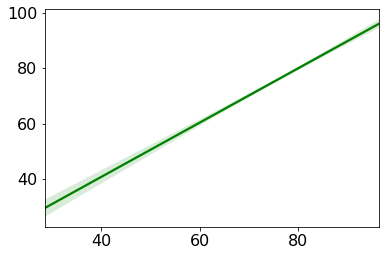

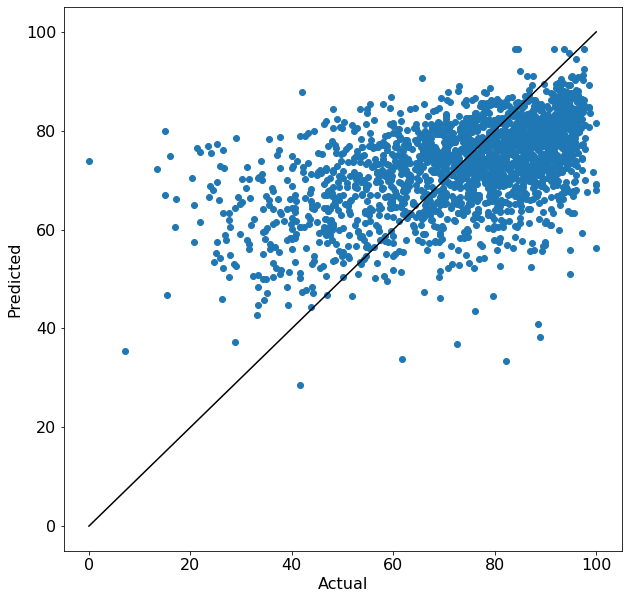

In [28]:
# Testing a visualization, but did not really get the results I wanted
sns.regplot(x=pred, y=y_test, scatter=False, fit_reg=True, color='g')

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test[0:2000], pred[0:2000]) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

#### Experiment 1 Results

| Model | Mean Squared Error  | Mean Absolute Error |
|---------------|----------|---------------------------|
| Linear Regression |0.0483 | 0.1701 |
| Support Vector Machine | 0.0491 | 0.1673 |
| Random Forest | 0.0498 | 0.1686 |

#### Experiment 2 with Feature Selection (only categorical variables)


Result: Linear regression did very poorly with the one hot encoded categorical variable matrix. SVM and Random Forest performed roughly the same.

In [29]:
# will be only categorical variables
pred_df = pd.concat([platform_df[['platforms:linux', 'platforms:mac']], age_df, owner_df,
                     genre_df[['genres:Violent', 'genres:Simulation', 'genres:Strategy', 'genres:Racing', 'genres:Gore', 'genres:Indie', 'genres:Sports',
                               'genres:Massively Multiplayer', 'genres:Free to Play']],
                     cat_df[['categories:In-App Purchases', 'categories:SteamVR Collectibles', 'categories:Single-player', 'categories:Steam Workshop',
                             'categories:Includes level editor', 'categories:Full controller support', 'categories:Multi-player', 'categories:Steam Trading Cards',
                             'categories:Captions available', 'categories:Shared/Split Screen', 'categories:Steam Leaderboards', 'categories:Local Multi-Player',
                             'categories:Steam Cloud', 'categories:Stats', 'categories:Local Co-op', 'categories:Steam Achievements', 'categories:MMO',
                             'categories:Online Multi-Player']],
                     tag_df[['steamspy_tags:Hidden Object', 'steamspy_tags:Racing', 'steamspy_tags:Classic', 'steamspy_tags:Sports', 'steamspy_tags:Survival',
                             'steamspy_tags:Story Rich', 'steamspy_tags:Atmospheric', 'steamspy_tags:Difficult', 'steamspy_tags:Indie', 'steamspy_tags:Cute',
                             'steamspy_tags:Violent', 'steamspy_tags:Platformer', 'steamspy_tags:Pixel Graphics', 'steamspy_tags:Comedy', 'steamspy_tags:Visual Novel',
                             'steamspy_tags:Strategy', 'steamspy_tags:Simulation', 'steamspy_tags:Great Soundtrack', 'steamspy_tags:Massively Multiplayer',
                             'steamspy_tags:Point & Click', 'steamspy_tags:Action', 'steamspy_tags:Free to Play', 'steamspy_tags:Anime', 'steamspy_tags:Co-op',
                             'steamspy_tags:Choices Matter', 'steamspy_tags:Twin Stick Shooter', 'steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle',
                             'steamspy_tags:Bullet Hell', 'steamspy_tags:Shoot \'Em Up']]], axis=1);
X = pred_df.to_numpy()
Y = df["rating"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Support Vector Machine 
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

Linear Regression
Mean Squared Error: 2.846370731392877e+27
Mean Absolute Error: 1778791154895.0168

SVM
Mean Squared Error: 267.3608313771424
Mean Absolute Error: 12.455404159481908

Random Forest
Mean Squared Error: 260.60412234169223
Mean Absolute Error: 12.507262832850882


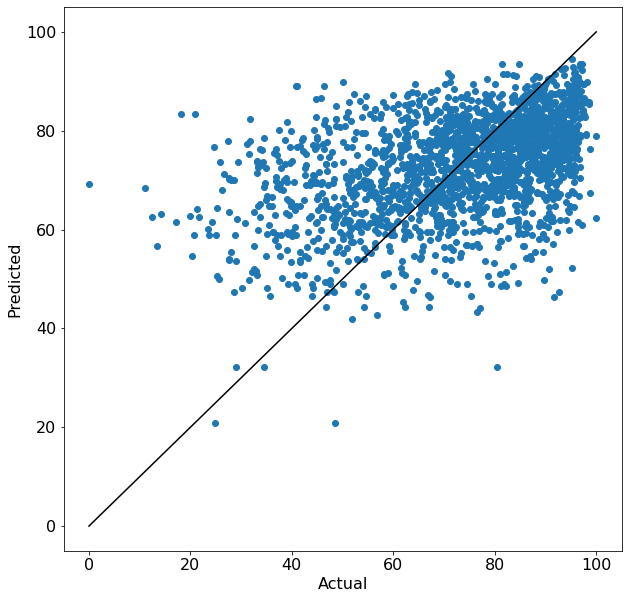

In [30]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test[0:2000], pred[0:2000]) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

#### Experiment 2 Results

| Model | Mean Squared Error  | Mean Absolute Error |
|---------------|----------|---------------------------|
| Linear Regression |3.3096e+22 | 2.0185x10^9 |
| Support Vector Machine | 0.0508 | 0.1688 |
| Random Forest | 0.0503 | 0.1688 |

#### Experiment 3 (with only numeric features)

Result: All models had roughly the same accuracy.

In [31]:
# will be only numeric variables
pred_df = df[['achievements', 'average_playtime', 'price', 'release_month']];
X = pred_df.to_numpy()
Y = df["rating"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Support Vector Machine
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

Linear Regression
Mean Squared Error: 283.56052568191143
Mean Absolute Error: 13.695983961288041

SVM
Mean Squared Error: 279.28024197625496
Mean Absolute Error: 13.11751409214126

Random Forest
Mean Squared Error: 284.4389202213521
Mean Absolute Error: 13.544229518168619


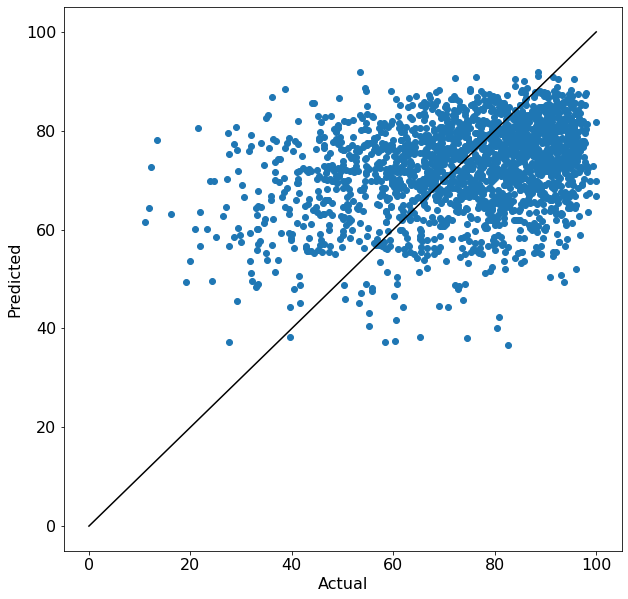

In [32]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test[0:2000], pred[0:2000]) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

### Experiment 4 - All predictive features that would be known at publishing time of a game. This would allow us to predict the rating of a game before anyone downloads it.

In [33]:
# not including average_playtime, achievements, owner features (would not be known before a game is published. All other features are included.)
pred_df = pd.concat([df[['english', 'price']], platform_df[['platforms:linux', 'platforms:mac']], age_df,
                     genre_df[['genres:Violent', 'genres:Simulation', 'genres:Strategy', 'genres:Racing', 'genres:Gore', 'genres:Indie', 'genres:Sports',
                               'genres:Massively Multiplayer', 'genres:Free to Play']],
                     cat_df[['categories:In-App Purchases', 'categories:SteamVR Collectibles', 'categories:Single-player', 'categories:Steam Workshop',
                             'categories:Includes level editor', 'categories:Full controller support', 'categories:Multi-player', 'categories:Steam Trading Cards',
                             'categories:Captions available', 'categories:Shared/Split Screen', 'categories:Steam Leaderboards', 'categories:Local Multi-Player',
                             'categories:Steam Cloud', 'categories:Stats', 'categories:Local Co-op', 'categories:Steam Achievements', 'categories:MMO',
                             'categories:Online Multi-Player']],
                     tag_df[['steamspy_tags:Hidden Object', 'steamspy_tags:Racing', 'steamspy_tags:Classic', 'steamspy_tags:Sports', 'steamspy_tags:Survival',
                             'steamspy_tags:Story Rich', 'steamspy_tags:Atmospheric', 'steamspy_tags:Difficult', 'steamspy_tags:Indie', 'steamspy_tags:Cute',
                             'steamspy_tags:Violent', 'steamspy_tags:Platformer', 'steamspy_tags:Pixel Graphics', 'steamspy_tags:Comedy', 'steamspy_tags:Visual Novel',
                             'steamspy_tags:Strategy', 'steamspy_tags:Simulation', 'steamspy_tags:Great Soundtrack', 'steamspy_tags:Massively Multiplayer',
                             'steamspy_tags:Point & Click', 'steamspy_tags:Action', 'steamspy_tags:Free to Play', 'steamspy_tags:Anime', 'steamspy_tags:Co-op',
                             'steamspy_tags:Choices Matter', 'steamspy_tags:Twin Stick Shooter', 'steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle',
                             'steamspy_tags:Bullet Hell', 'steamspy_tags:Shoot \'Em Up']]], axis=1);
X = pred_df.to_numpy()
Y = df["rating"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

Linear Regression
Mean Squared Error: 248.92790172874206
Mean Absolute Error: 12.48624653260667
R2 Score: 0.1852195572352351
Predictions: 73.10208308218083 ± 7.850080685658129



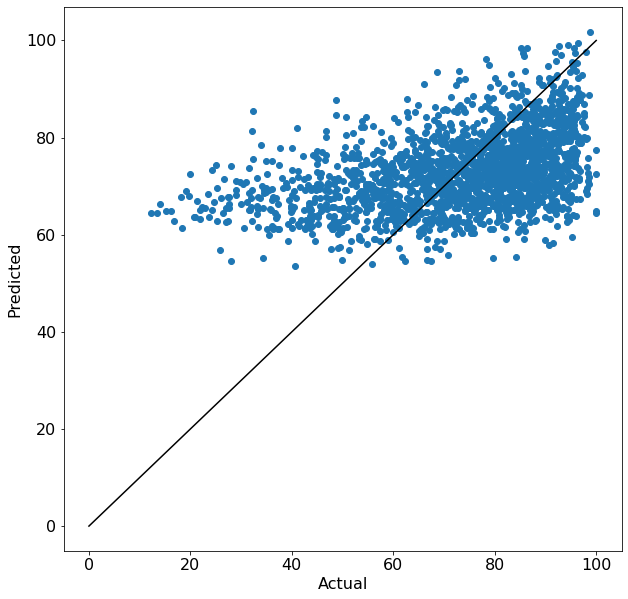

In [34]:
# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))
print("R2 Score: " + str(metrics.r2_score(y_test, pred)))
print("Predictions: " + str(pred.mean()) + " ± " + str(pred.std()) + "\n")
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test[0:2000], pred[0:2000]) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

SVM
Mean Squared Error: 254.41261595384125
Mean Absolute Error: 12.230309168696929
R2 Score: 0.16726721901308506
Predictions: 75.95606630021726 ± 6.817141742856119



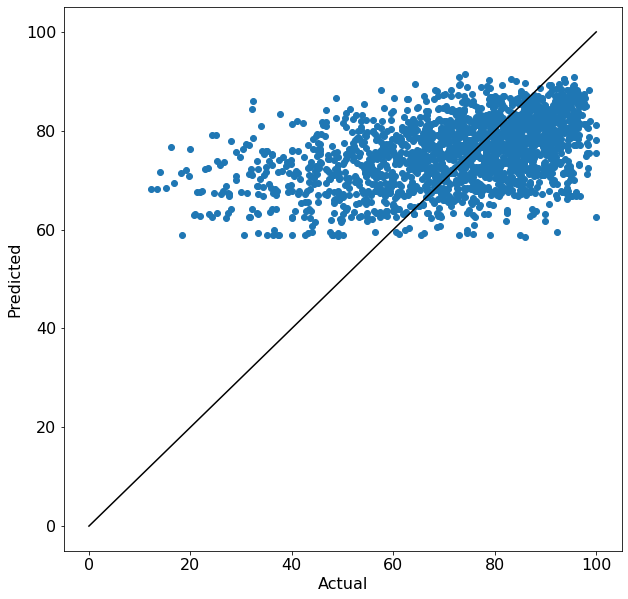

In [35]:
# Support Vector Machine
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))
print("R2 Score: " + str(metrics.r2_score(y_test, pred)))
print("Predictions: " + str(pred.mean()) + " ± " + str(pred.std()) + "\n")
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test[0:2000], pred[0:2000]) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

Random Forest
Mean Squared Error: 255.48080755290496
Mean Absolute Error: 12.389638793106347
R2 Score: 0.16377085874973796
Predictions: 72.88205284717783 ± 10.203296585832973
Actual: 73.10726798117321 ± 17.661067601607705


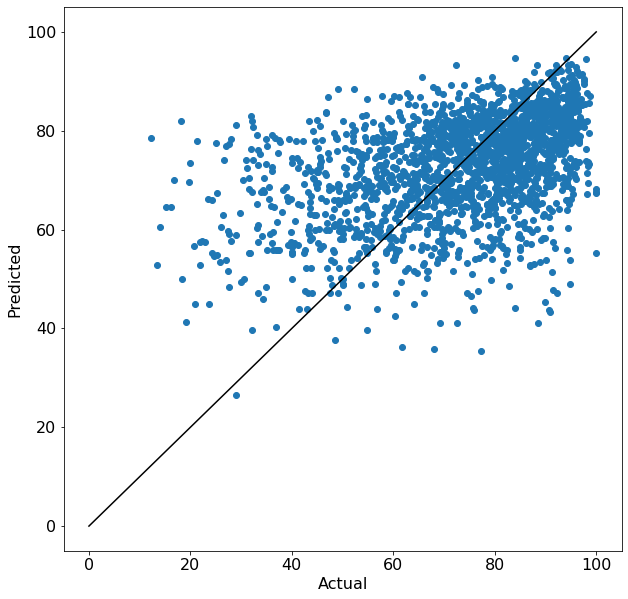

In [36]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))
print("R2 Score: " + str(metrics.r2_score(y_test, pred)))
print("Predictions: " + str(pred.mean()) + " ± " + str(pred.std()))
print("Actual: " + str(df['rating'].mean()) + " ± " + str(df['rating'].std()))

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test[0:2000], pred[0:2000]) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

### Experiment 5 - Only the best features

In [37]:
# will be only categorical variables
pred_df = pd.concat([platform_df[['platforms:linux', 'platforms:mac']], age_df, owner_df,
                     genre_df[['genres:Simulation', 'genres:Massively Multiplayer']],
                     cat_df[['categories:In-App Purchases', 'categories:SteamVR Collectibles', 'categories:Single-player', 'categories:Steam Workshop',
                             'categories:Includes level editor', 'categories:Full controller support', 'categories:Multi-player', 'categories:Steam Trading Cards',
                             'categories:Captions available', 'categories:Shared/Split Screen', 'categories:Steam Leaderboards', 'categories:Local Multi-Player',
                             'categories:Steam Cloud', 'categories:Stats', 'categories:Local Co-op', 'categories:Steam Achievements', ]],
                     tag_df[['steamspy_tags:Hidden Object', 'steamspy_tags:Racing', 'steamspy_tags:Classic', 'steamspy_tags:Sports', 'steamspy_tags:Survival',
                             'steamspy_tags:Story Rich', 'steamspy_tags:Atmospheric', 'steamspy_tags:Difficult', 'steamspy_tags:Indie', 'steamspy_tags:Cute',
                             'steamspy_tags:Violent', 'steamspy_tags:Platformer', 'steamspy_tags:Pixel Graphics', 'steamspy_tags:Comedy', 'steamspy_tags:Visual Novel',
                             'steamspy_tags:Strategy', 'steamspy_tags:Simulation', 'steamspy_tags:Great Soundtrack', 'steamspy_tags:Massively Multiplayer',
                             'steamspy_tags:Point & Click', 'steamspy_tags:Action', 'steamspy_tags:Free to Play', 'steamspy_tags:Anime', 'steamspy_tags:Co-op',
                             'steamspy_tags:Choices Matter', 'steamspy_tags:Twin Stick Shooter', 'steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle',
                             'steamspy_tags:Bullet Hell', 'steamspy_tags:Shoot \'Em Up']]], axis=1);
X = pred_df.to_numpy()
Y = df["rating"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Support Vector Machine 
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

Linear Regression
Mean Squared Error: 3.45426788266478e+27
Mean Absolute Error: 1165250918186.5962

SVM
Mean Squared Error: 265.14588848917583
Mean Absolute Error: 12.380259916394978

Random Forest
Mean Squared Error: 263.06604112240245
Mean Absolute Error: 12.733473565251394


In [38]:
df['rating'].mean()

print("Actual: " + str(df['rating'].mean()) + " ± " + str(df['rating'].std()))

Actual: 73.10726798117321 ± 17.661067601607705


In [39]:
# Mean Absolute Error is the average error per prediction - therefore ~17% average error for each prediction
# Mean Squared Error penalizes larger errors more, but since we are dealing with a label vector with values 0-1, it seems small
# If we instead make our label vector represent the rating 0-100, then our MSE is also increased by a factor of 10000 (100^2)
# b/c of this, the square root of the MSE is greater than MAE. Which implies that while there are predictions with errors that are much
# larger than 17% being calculated rather than most estimations being off by a smaller amount.